# General Algorithm For Course (version 0.2)
1. Remove essential nodes and clean up network
2. Perform Markov Cluster Algorithm (MCL) setting numnodes in the nieghbourhood of 200/300. 
3. Create new network, where each node represents the clusters:
  - Weighted network option with weights set to number of connections between cluster a and cluster b
  - Unweighted set by direct connection.
4. Perform centrality analysis on the cluster network and identify important clusters.
5. Find shortest path nodes for important clusters as proteins of inteerest.

In [1]:
import networkx as nx
import markov_clustering as mc
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import func

In [2]:
# These are the essential proteins that the biochemist have identified 
# https://docs.google.com/document/d/12kaAjgjEsQtCOaRqw6g2ZNeLzN-rlzmLaGApKCdI1uc/edit 
# E3 protein is LPD1
names = ['LPD1', 'PDA1', 'PYC2', 'PDB1', 'PTC1', 'BAT2', 'KGD1', 'AIM22', 'PKP1', 'PTC5', 'LAT1']

important_nodes = func.parser(names)
print(important_nodes)

{'LPD1': '4932.YFL018C', 'PDA1': '4932.YER178W', 'PYC2': '4932.YBR218C', 'PDB1': '4932.YBR221C', 'PTC1': '4932.YDL006W', 'BAT2': '4932.YJR148W', 'KGD1': '4932.YIL125W', 'AIM22': '4932.YJL046W', 'PKP1': '4932.YIL042C', 'PTC5': '4932.YOR090C', 'LAT1': '4932.YNL071W'}


In [3]:
# Creates the network and removes initial nodes 
network_name = "network_info/4932_protein_links_v11_5.txt"
G = func.remove_threshold(network_name, 700)

essential_proteins = "network_info/essential_proteins.csv"
G = func.remove_essential(G, essential_proteins)

print(G)

Graph with 5098 nodes and 53550 edges


In [4]:
#Finds clusters

# Here we are going to lose the protein names as the matrix gets assigned to their index. 
# So we recover that with a hash table (dictionary)
adj_matrix = nx.adjacency_matrix(G) 

# Create a hash table that takes takes a number and returns a protein name
protein_hash = {}
for index, node in enumerate(G.nodes):
    protein_hash[index] = node

/var/folders/qm/5krpz0vd1n5g2tknvt69wkx00000gn/T/ipykernel_92636/645912874.py:5: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = nx.adjacency_matrix(G)


In [5]:
#Runs MCL 

# expansion parameter and inflation parameter tuned
# result = mc.run_mcl(adj_matrix, expansion = 2, inflation = 1.04)  

# run with default parameters    
result = mc.run_mcl(adj_matrix)         
clusters = mc.get_clusters(result) 

In [6]:
# finds how many clusters there are

# When running 
# E = 2, I = 2  --> Number of Cluster = 1050
#               --> Nodes = 5098

# E = 10, I = 2 --> Number of Clusters = 469
#               --> Nodes = 5098
# print(type(clusters))
# print(type(clusters[0]))
# print(type(clusters[0][0]))


num_clusters = len(clusters)
print(f"The number of clusters {num_clusters}") 

# finds the total number of nodes from the MCL
counter = 0
for cluster in clusters:
    counter += len(cluster)
print(f"The total number of nodes {counter}") 

# The average cluster size
print(f"The average cluster size is {counter/num_clusters}")

The number of clusters 1050
The total number of nodes 5098
The average cluster size is 4.855238095238096


In [7]:
# Renaming proteins in the clusters
named_clusters = func.renaming_clusters(clusters, protein_hash)
print(len(named_clusters)) #check that no clusters were lost

1050


Graph with 1050 nodes and 5305 edges


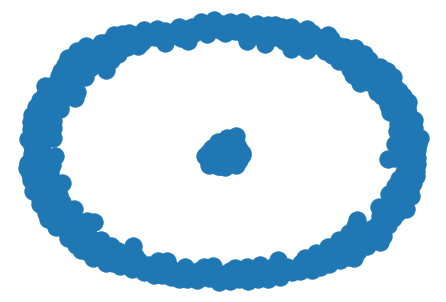

In [8]:
weighted_network = func.convert_to_weighted(G, named_clusters)
print(weighted_network)
nx.draw(weighted_network)

{}

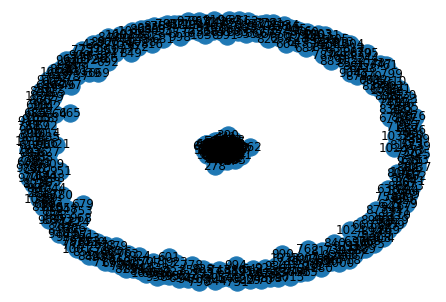

In [9]:
#Finds positions of nodes
pos = nx.spring_layout(weighted_network)

# plots it
nx.draw(weighted_network, pos, with_labels = True)
labels = nx.get_edge_attributes(G,'weight')

#adds the edges in
nx.draw_networkx_edge_labels(weighted_network, pos, edge_labels=labels)

In [10]:
# finds cluster that the LPD1 or E3 protein is in
# Very interesting, alot of the proteins are int he same cluster
for key, value in important_nodes.items():
    print(func.find_cluster(value, named_clusters), key)

32 LPD1
32 PDA1
32 PYC2
32 PDB1
123 PTC1
93 BAT2
32 KGD1
190 AIM22
464 PKP1
330 PTC5
32 LAT1


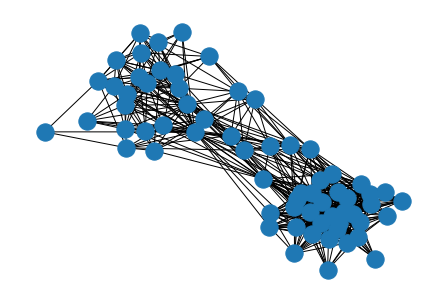

In [11]:
#Make a graph with only nodes in a certain cluster 
#cluster number 32 in this case as it has LPD1
cluster_network = func.cluster_graph(G, named_clusters[32], named_clusters[93])
nx.draw(cluster_network)

In [16]:
b_centrality = func.between_centrality(G, named_clusters[32], named_clusters[93])

In [18]:
# sorts the dictionary such that highest centrality is first
sorted_betweeness = dict(sorted(b_centrality.items(), key = lambda x: -x[1]))

# for key, val in sorted_betweeness.items():
#     print(f"The node {key} has a betweenness centrality score of {val}")

# gives first 5 maybe or more to BCMB students
prefered_names = func.parser(b_centrality.keys(), False)
print(prefered_names)


{'4932.YNL037C': 'IDH1', '4932.YLR304C': 'ACO1', '4932.YNR001C': 'CIT1', '4932.YIL125W': 'KGD1', '4932.YPL262W': 'FUM1', '4932.YOL126C': 'MDH2', '4932.YBR218C': 'PYC2', '4932.YBR221C': 'PDB1', '4932.YKL085W': 'MDH1', '4932.YDL078C': 'MDH3', '4932.YGL062W': 'PYC1', '4932.YKR097W': 'PCK1', '4932.YAL054C': 'ACS1', '4932.YOR142W': 'LSC1', '4932.YER065C': 'ICL1', '4932.YDR148C': 'KGD2', '4932.YKL029C': 'MAE1', '4932.YER178W': 'PDA1', '4932.YNL071W': 'LAT1', '4932.YGR193C': 'PDX1', '4932.YFL018C': 'LPD1', '4932.YCR005C': 'CIT2', '4932.YLR174W': 'IDP2', '4932.YPR001W': 'CIT3', '4932.YBL015W': 'ACH1', '4932.YNL117W': 'MLS1', '4932.YOR136W': 'IDH2', '4932.YNL009W': 'IDP3', '4932.YDL066W': 'IDP1', '4932.YBR006W': 'UGA2', '4932.YOR388C': 'FDH1', '4932.YJL200C': 'ACO2', '4932.YPR006C': 'ICL2', '4932.YHR208W': 'BAT1', '4932.YJR148W': 'BAT2', '4932.YOR108W': 'LEU9', '4932.YNL104C': 'LEU4', '4932.YGL009C': 'LEU1', '4932.YMR108W': 'ILV2', '4932.YCL009C': 'ILV6', '4932.YDR354W': 'TRP4', '4932.YCR053W':